In [1]:
import sys
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install tf-nightly

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image

from tensorflow.keras import callbacks

In [3]:
import scipy
import pathlib
import matplotlib.pyplot as plt

### Load dataset

In [4]:
batch_size = 32
img_height = 256
img_width = 256

data_dir = pathlib.Path("./Images_RDTs/Single")

image_count_p = len(list(data_dir.glob('POSITIVE/*')))
image_count_n = len(list(data_dir.glob('NEGATIVE/*')))

image_count = image_count_p + image_count_n
print(image_count)

2538


### Train/Test split

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    color_mode='grayscale',
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    label_mode = 'categorical',
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    color_mode='grayscale',
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    label_mode = 'categorical',
    batch_size=batch_size)

Found 2538 files belonging to 2 classes.
Using 2031 files for training.
Found 2538 files belonging to 2 classes.
Using 507 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['NEGATIVE', 'POSITIVE']


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


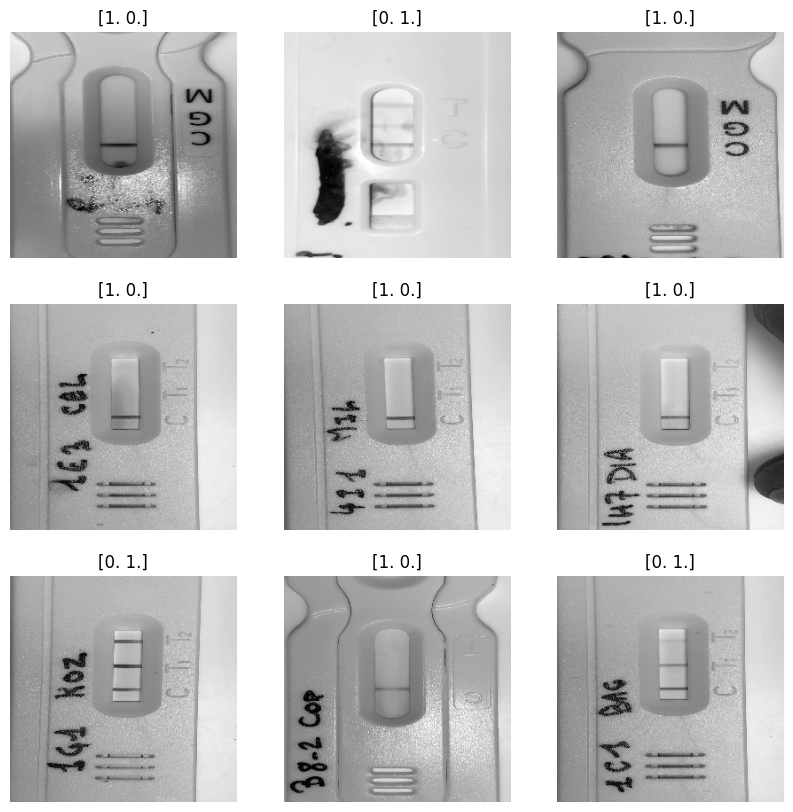

(32, 256, 256, 1)
(32, 2)


In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(np.array(labels[i]))
        plt.axis("off")
        
plt.show()

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

### Caching to improve speed

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Save best model

In [9]:
best5_path = 'best_nor.hdf5'
mcp_save_best = callbacks.ModelCheckpoint(filepath = best5_path, 
                                monitor='val_loss',
                                verbose=1, 
                                save_best_only=True,  
                                mode ='min')

callbacks = [mcp_save_best]

### Sample-wise center

In [10]:
class Samplewise_center(keras.layers.Layer):
    
    def __init__(self):
        super(Samplewise_center, self).__init__()
        
    def call(self, inputs):
        x = tf.reduce_mean(inputs)
        y = tf.subtract(inputs, x)
        z = tf.math.reduce_std(inputs) + 1e-7
        
        return y
        
        #np.mean(inputs, axis=img_channel_index, keepdims=True)
        #return tf.divide(y, x)
      

### Data augmentation

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("vertical", seed = 123,
                      input_shape=(img_height,
                                  img_width,
                                  1)),
        layers.RandomTranslation(height_factor = 0.2, width_factor = 0.1, seed = 123, fill_mode = "nearest"),
        layers.RandomZoom(0.2, seed = 123),
        layers.RandomBrightness(0.1, seed = 123)
    ]
)


In [12]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    Samplewise_center(),
    layers.Rescaling(1./255),
    #sample_centering,
    #layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    
    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 1)       0         
                                                                 
 samplewise_center (Samplewi  (None, 256, 256, 1)      0         
 se_center)                                                      
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)     

In [14]:
epochs=200

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/200
63/64 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.5948
Epoch 1: val_loss improved from inf to 0.62835, saving model to best_nor.hdf5
64/64 [==============================] - 8s 52ms/step - loss: 0.6588 - accuracy: 0.5963 - val_loss: 0.6284 - val_accuracy: 0.6686
Epoch 2/200
63/64 [============================>.] - ETA: 0s - loss: 0.5989 - accuracy: 0.6738
Epoch 2: val_loss improved from 0.62835 to 0.49684, saving model to best_nor.hdf5
64/64 [==============================] - 3s 53ms/step - loss: 0.5989 - accuracy: 0.6736 - val_loss: 0.4968 - val_accuracy: 0.7495
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 0.5754 - accuracy: 0.6898
Epoch 3: val_loss improved from 0.49684 to 0.43831, saving model to best_nor.hdf5
64/64 [==============================] - 3s 47ms/step - loss: 0.5754 - accuracy: 0.6898 - val_loss: 0.4383 - val_accuracy: 0.7870
Epoch 4/200
64/64 [==============================] - ETA: 0s - loss: 0.5022 - accur

64/64 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.9586
Epoch 29: val_loss improved from 0.07535 to 0.06945, saving model to best_nor.hdf5
64/64 [==============================] - 3s 42ms/step - loss: 0.1051 - accuracy: 0.9586 - val_loss: 0.0695 - val_accuracy: 0.9842
Epoch 30/200
63/64 [============================>.] - ETA: 0s - loss: 0.1025 - accuracy: 0.9630
Epoch 30: val_loss did not improve from 0.06945
64/64 [==============================] - 3s 40ms/step - loss: 0.1011 - accuracy: 0.9636 - val_loss: 0.0747 - val_accuracy: 0.9704
Epoch 31/200
63/64 [============================>.] - ETA: 0s - loss: 0.0926 - accuracy: 0.9705
Epoch 31: val_loss did not improve from 0.06945
64/64 [==============================] - 2s 32ms/step - loss: 0.0916 - accuracy: 0.9710 - val_loss: 0.0790 - val_accuracy: 0.9704
Epoch 32/200
64/64 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9577
Epoch 32: val_loss improved from 0.06945 to 0.06257, saving 

64/64 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.9749
Epoch 58: val_loss did not improve from 0.05652
64/64 [==============================] - 2s 32ms/step - loss: 0.0662 - accuracy: 0.9749 - val_loss: 0.0718 - val_accuracy: 0.9783
Epoch 59/200
64/64 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9739
Epoch 59: val_loss did not improve from 0.05652
64/64 [==============================] - 2s 31ms/step - loss: 0.0716 - accuracy: 0.9739 - val_loss: 0.0754 - val_accuracy: 0.9665
Epoch 60/200
63/64 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9805
Epoch 60: val_loss did not improve from 0.05652
64/64 [==============================] - 2s 36ms/step - loss: 0.0543 - accuracy: 0.9808 - val_loss: 0.0784 - val_accuracy: 0.9763
Epoch 61/200
63/64 [============================>.] - ETA: 0s - loss: 0.0699 - accuracy: 0.9760
Epoch 61: val_loss did not improve from 0.05652
64/64 [==============================] - 2s 35m

Epoch 88/200
64/64 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9793
Epoch 88: val_loss did not improve from 0.05192
64/64 [==============================] - 2s 32ms/step - loss: 0.0539 - accuracy: 0.9793 - val_loss: 0.0527 - val_accuracy: 0.9763
Epoch 89/200
64/64 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9808
Epoch 89: val_loss did not improve from 0.05192
64/64 [==============================] - 2s 32ms/step - loss: 0.0497 - accuracy: 0.9808 - val_loss: 0.0554 - val_accuracy: 0.9803
Epoch 90/200
64/64 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9842
Epoch 90: val_loss did not improve from 0.05192
64/64 [==============================] - 2s 31ms/step - loss: 0.0453 - accuracy: 0.9842 - val_loss: 0.0688 - val_accuracy: 0.9783
Epoch 91/200
63/64 [============================>.] - ETA: 0s - loss: 0.0475 - accuracy: 0.9797
Epoch 91: val_loss did not improve from 0.05192
64/64 [===========================

Epoch 118/200
64/64 [==============================] - ETA: 0s - loss: 0.0427 - accuracy: 0.9808
Epoch 118: val_loss did not improve from 0.04068
64/64 [==============================] - 2s 31ms/step - loss: 0.0427 - accuracy: 0.9808 - val_loss: 0.0508 - val_accuracy: 0.9822
Epoch 119/200
64/64 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9842
Epoch 119: val_loss did not improve from 0.04068
64/64 [==============================] - 2s 32ms/step - loss: 0.0408 - accuracy: 0.9842 - val_loss: 0.0646 - val_accuracy: 0.9803
Epoch 120/200
64/64 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9857
Epoch 120: val_loss did not improve from 0.04068
64/64 [==============================] - 2s 32ms/step - loss: 0.0338 - accuracy: 0.9857 - val_loss: 0.0715 - val_accuracy: 0.9744
Epoch 121/200
64/64 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9887
Epoch 121: val_loss did not improve from 0.04068
64/64 [===================

Epoch 148/200
64/64 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9882
Epoch 148: val_loss did not improve from 0.04068
64/64 [==============================] - 2s 31ms/step - loss: 0.0346 - accuracy: 0.9882 - val_loss: 0.0640 - val_accuracy: 0.9822
Epoch 149/200
64/64 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.9867
Epoch 149: val_loss did not improve from 0.04068
64/64 [==============================] - 2s 31ms/step - loss: 0.0339 - accuracy: 0.9867 - val_loss: 0.0620 - val_accuracy: 0.9822
Epoch 150/200
64/64 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9897
Epoch 150: val_loss did not improve from 0.04068
64/64 [==============================] - 2s 31ms/step - loss: 0.0244 - accuracy: 0.9897 - val_loss: 0.0643 - val_accuracy: 0.9803
Epoch 151/200
64/64 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9877
Epoch 151: val_loss did not improve from 0.04068
64/64 [===================

Epoch 178/200
64/64 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9897
Epoch 178: val_loss did not improve from 0.04068
64/64 [==============================] - 2s 31ms/step - loss: 0.0290 - accuracy: 0.9897 - val_loss: 0.0454 - val_accuracy: 0.9901
Epoch 179/200
64/64 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9892
Epoch 179: val_loss did not improve from 0.04068
64/64 [==============================] - 2s 31ms/step - loss: 0.0306 - accuracy: 0.9892 - val_loss: 0.0655 - val_accuracy: 0.9803
Epoch 180/200
63/64 [============================>.] - ETA: 0s - loss: 0.0337 - accuracy: 0.9870
Epoch 180: val_loss did not improve from 0.04068
64/64 [==============================] - 2s 32ms/step - loss: 0.0334 - accuracy: 0.9872 - val_loss: 0.0687 - val_accuracy: 0.9763
Epoch 181/200
64/64 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9892
Epoch 181: val_loss did not improve from 0.04068
64/64 [===================

## Get back the best model

Source: https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md

In [15]:
model.load_weights('best_nor.hdf5')

In [16]:
# Get each layer, starting from the Conv layer
layer_outputs = [layer.output for layer in model.layers[3:]] 

len(layer_outputs)

14

In [17]:
activation_model = keras.models.Model(inputs=model.layers[3].input, outputs=layer_outputs)

#### Load a test image

In [18]:
test_img_path = "./img_testing/index.jpeg"

img = image.load_img(test_img_path, color_mode="grayscale", target_size=(img_height, img_width))

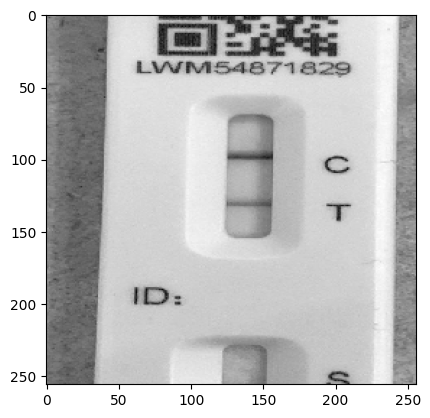

In [19]:
img_tensor = image.img_to_array(img)

m = img_tensor.mean()
img_tensor -= m

plt.imshow(img_tensor, cmap='gray')
plt.show()

img_tensor = np.expand_dims(img_tensor, axis=0)
#img_tensor /= 255.

In [20]:
classes = model.predict(img_tensor)
print("Predicted class is:",classes)

score = tf.nn.softmax(classes[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 218ms/step
Predicted class is: [[-3.7742286  1.2224935]]
This image most likely belongs to POSITIVE with a 99.33 percent confidence.


### Get the shape of activation for the first layer

In [22]:
activations = activation_model.predict(img_tensor) 

first_layer_activation = activations[0]
print(first_layer_activation.shape)

1/1 [==============================] - 0s 120ms/step
(1, 256, 256, 16)


In [33]:
r_num_img = 16

print(len(activations))
count = 0

for layer_activation in activations[:-3]:
    
    
    # Number of features in the feature map
    n_features = layer_activation.shape[-1] 
    #The feature map has shape (1, size, size, n_features).
    size = layer_activation.shape[1] 
    # Tiles the activation channels in this matrix
    n_cols = n_features // r_num_img 
    
    display_grid = np.zeros((size * n_cols, r_num_img * size))
    
    print(layer_activation.shape)
    
    for col in range(n_cols): 
        for row in range(r_num_img):
            
            channel_image = layer_activation[0, :, :, col * r_num_img + row]
            
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            
            
            display_grid[col * size : (col + 1) * size, # Displays the grid
                        row * size : (row + 1) * size] = channel_image
        
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')
    plt.savefig(str(count))
    count = count + 1
    plt.close()

14
(1, 256, 256, 16)
(1, 128, 128, 16)
(1, 128, 128, 32)
(1, 64, 64, 32)
(1, 64, 64, 64)
(1, 32, 32, 64)
(1, 32, 32, 128)
(1, 16, 16, 128)
(1, 16, 16, 256)
(1, 8, 8, 256)
(1, 8, 8, 256)
